# PS2

    

In [7]:
%matplotlib notebook
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
LenderData = pd.read_csv("LenderData.csv")


## 1 a)

## 1 b) For graph please see above.
$$f(x\mid \mu, \sigma)=\frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{(ln(x)-\mu)^2}{2\sigma^2}}$$

<IPython.core.display.Javascript object>


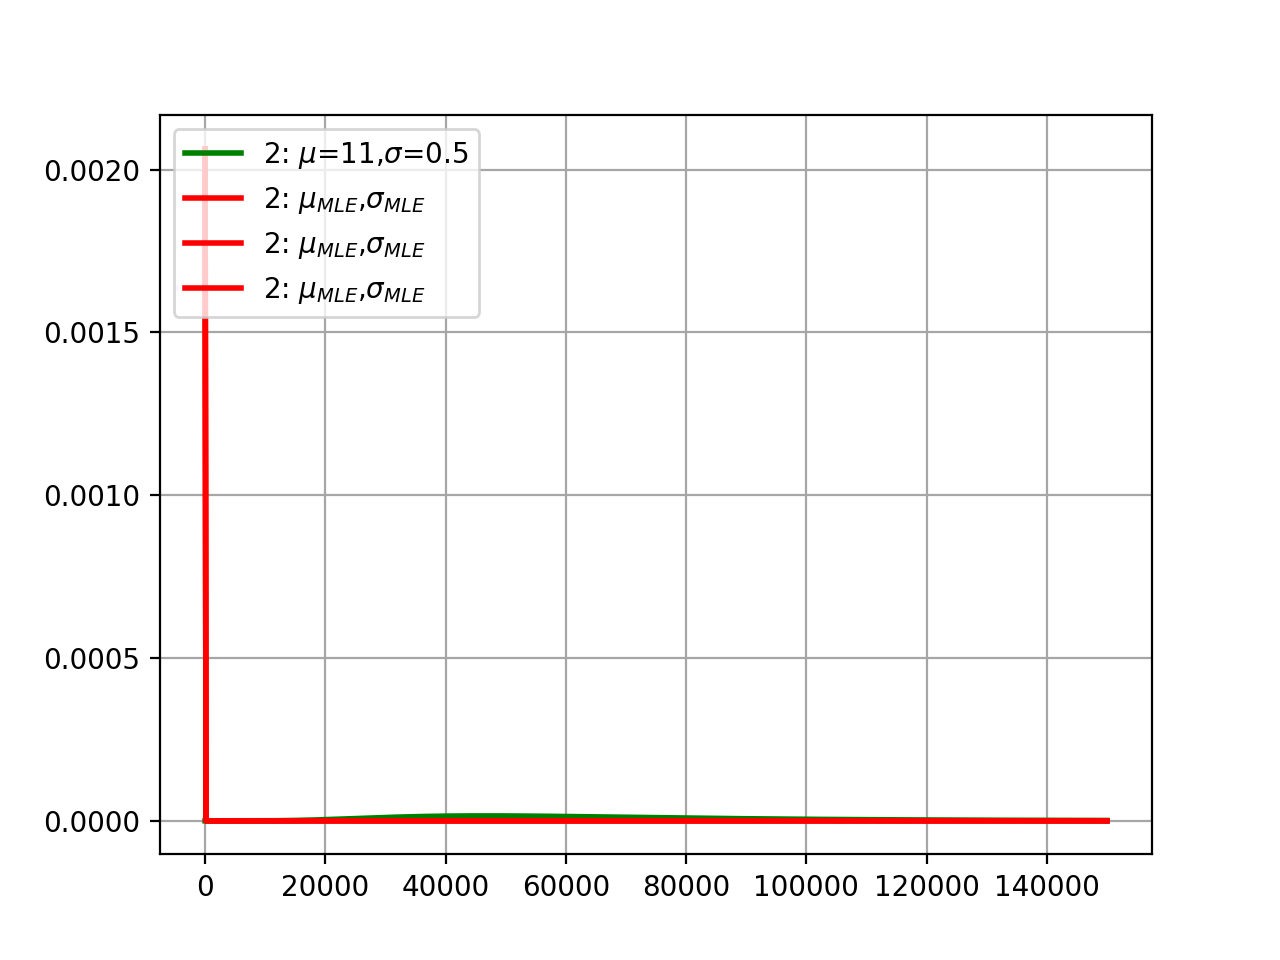

In [8]:
def dg_lnpdf(sigma, mu, xvec,cutoff):
#     xvec = np.linspace(lb,ub,grain)
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = (1/(xvec*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvec) - mu)**2 / (2 * sigma**2))  /prob_notcut)

    return pdf_vals

grain = 1000

dist_pts = np.linspace(0.01, 150000,grain)
mu_1 = 60000
sig_1 = 5000
pdf_vals = dg_lnpdf(0.5,11.0,dist_pts,150000) #, plot=False

plt.plot(dist_pts, pdf_vals,linewidth=2, color='g', label='2: $\mu$=11,$\sigma$=0.5')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
# plt.title(f'Plot of Log Normal PDF with sigma={sig_1} and mean={mu_1}')
# plt.ylabel(r' (\$000s)')
plt.legend(loc='upper left')


In [10]:
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = dg_lnpdf(sigma, mu, xvals, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val
print (f"The log likelyhood where sigma=5000 and mean =60000 is {log_lik_truncnorm(incomes,mu_1,sig_1,150000)}")

The log likelyhood where sigma=5000 and mean =60000 is -18553.579130869795


 ## 1 c) For graph please see above.

In [11]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [16]:
import scipy.optimize as opt
mu_init = mu_1
sig_init = sig_1
params_init = np.array([mu_init, sig_init])
mle_args = (LenderData, 'None')
results = opt.minimize(crit, params_init, args=(mle_args), 
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


ValueError: setting an array element with a sequence.

In [18]:
plt.plot(dist_pts, dg_lnpdf(sig_MLE,mu_MLE,dist_pts,'None'),linewidth=2, color='r', label='2: $\mu_{MLE}$,$\sigma_{MLE}$')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
# plt.title(f'Plot of Log Normal PDF with sigma={sig_1} and mean={mu_1}')
# plt.ylabel(r' (\$000s)')
plt.legend(loc='upper left')
print (f"The log likelihood using MLE is {log_lik_truncnorm(incomes,mu_MLE,sig_MLE,150000)}")

The log likelihood using MLE is -4429.49162393734


In [19]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 1. -0.]
 [-0.  1.]]
Standard error for mu estimate =  1.0
Standard error for sigma estimate =  1.0


## 1d) 

In [215]:
log_lik_h0 = log_lik_truncnorm(incomes, mu_1, sig_1,150000)
log_lik_mle = log_lik_truncnorm(incomes, mu_MLE, sig_MLE,150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print(f'chi squared of H0 with 2 degrees of freedom p-value = {pval_h0}, h0 is rejectced.')
print (f'mu is probably not {mu_1} and sigma is p not {sig_1}')

chi squared of H0 with 2 degrees of freedom p-value = 0.0, h0 is rejectced.
mu is probably not 11.0 and sigma is p not 0.5


## 1e)

In [216]:
p_1 =  1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_2 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print("The probability that MACSS students will earn more than $100,000 is {:.2f} and \
the probability they earn less than $75,000 is {:.2f}.".format(p_1, p_2))


The probability that MACSS students will earn more than $100,000 is 0.23 and the probability they earn less than $75,000 is 0.26.


## 2 a)

In [217]:
data =  pd.read_csv('sick.txt')
plt.hist(data.sick)
data.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [226]:
def get_error_sum(params,var_list):
    age, children, winter, sick= var_list
    b0, b1, b2, b3, sigma = params
#     print(np.sum((sick-b0-b1*age-b2*children-b3*winter)**2))
    return np.sum((sick-b0-b1*age-b2*children-b3*winter)**2)
def crit(params,*args):
    age, children, winter, sick= args
    b0, b1, b2, b3, sigma = params
    n=len(age)
    log_lik_val = -n/2*np.log(2*np.pi)-n*np.log(sigma)-1/(2*sigma**2)*get_error_sum(params,(age, children, winter, sick))
    return -log_lik_val
age = data.age
children = data.children
winter = data.avgtemp_winter
sick = data.sick
params_init = (1,0,0,0,1)
# print(crit(params_init,age, children, winter,sick))
results = opt.minimize(crit, params_init, args=((age, children, winter, sick)),  method = 'L-BFGS-B',bounds=((0.1, None),\
                       (0.01, None), (0.1, None), (None, -0.001), (0.001, None)))
print (f'The estimatesa are {results.x} for b0, b1, b2, b3 and sigma')
print (f'The log likelihood is {crit(params_init,age, children, winter,sick)}.')

The estimatesa are [ 0.25164352  0.01293353  0.40050053 -0.00999171  0.00301796] for b0, b1, b2, b3 and sigma
The log likelihood is 209.09200664093453.


In [219]:
OffDiagNeg = np.eye(5)*2-1
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  4.13735128  -0.81559561   3.56828087   0.43455863  10.80675784]
 [ -0.81559561   0.16358802   0.71968201   0.08682704   2.16380181]
 [  3.56828087   0.71968201   3.17166638  -0.3815182   -9.51409631]
 [  0.43455863   0.08682704  -0.3815182    0.04612404  -1.14891346]
 [ 10.80675784   2.16380181  -9.51409631  -1.14891346  28.62588617]]
Standard error for mu estimate =  2.0340480042
Standard error for sigma estimate =  0.404460154036


In [220]:
results.fun

-876.86507040474964

In [190]:

params_h0 = np.array([1,0,0,0,0.1])
log_lik_h0 = -crit(params_h0, age, children, winter,sick)
log_lik_mle = -crit(results.x, age, children, winter,sick)
pval_h0 = 1.0 - sts.chi2.cdf(2 * (log_lik_mle - log_lik_h0), 5)
print('The p_value is {}. Hypothesis is rejected.'.format(pval_h0))


The p_value is 0.0. Hypothesis is rejected.
